In [41]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [43]:
#!pip install catboost

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

#from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [47]:
#myfolder = "./"
myfolder = "data/CMaps/"

# **Columns' names**

In [50]:
#Columns' names
'''
1)  unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  21
'''
unitNames = ['UnitNumber']
timeCycles = ["TimeInCycles"]
operSets = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes = ["SensorMes"+str(j) for j in range(1, 22)] # de 1 à 21
columnsNames = unitNames + timeCycles + operSets +sensorMes

# **Datasets loading**

In [53]:
def data_loading(x):
  train_path = myfolder + "train_"+ x +".txt"
  test_path = myfolder + "test_"+ x +".txt"
  rul_path = myfolder + "RUL_"+ x +".txt"
  train = pd.read_csv(train_path, delim_whitespace=True, names=columnsNames)
  test = pd.read_csv(test_path, delim_whitespace=True, names=columnsNames)
  rul = pd.read_csv(rul_path, delim_whitespace=True, names=["RUL_FD"])
  return train, test, rul

train_fd001, test_fd001, rul_fd001 = data_loading("FD001")
train_fd002, test_fd002, rul_fd002 = data_loading("FD002")
train_fd003, test_fd003, rul_fd003 = data_loading("FD003")
train_fd004, test_fd004, rul_fd004 = data_loading("FD004")

In [54]:
# Forcer l'affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


# **RUL column generation for train and test set**

In [56]:
def rul_train_generation(x):
  rul = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  rul.columns = ['UnitNumber', 'max']
  x = x.merge(rul, on=['UnitNumber'], how='left')
  x['RUL'] = x['max'] - x['TimeInCycles']
  x.drop('max', axis=1, inplace=True)
  return x

train_fd001 = rul_train_generation(train_fd001)
train_fd002 = rul_train_generation(train_fd002)
train_fd003 = rul_train_generation(train_fd003)
train_fd004 = rul_train_generation(train_fd004)

In [57]:
train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


In [58]:
def rul_test_generation(x, rul):

  rul["UnitNumber"] = rul.index + 1 # +1 pour que UnitNumber demarre de 1 au lieu de 0, car il s'agit du numero des moteur

  x = x.merge(rul, on=['UnitNumber'], how='left')

  max_cycle = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  max_cycle.columns = ['UnitNumber', 'max']
  x = x.merge(max_cycle, on=['UnitNumber'], how='left')
  x['RUL'] = x['RUL_FD'] + x['max'] - x['TimeInCycles']
  x.drop(['max', 'RUL_FD'], axis=1, inplace=True)

  return x

test_fd001 = rul_test_generation(test_fd001, rul_fd001)
test_fd002 = rul_test_generation(test_fd002, rul_fd002)
test_fd003 = rul_test_generation(test_fd003, rul_fd003)
test_fd004 = rul_test_generation(test_fd004, rul_fd004)

In [59]:
test_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249


In [66]:
print("train_FD001: ",train_fd001.shape, ". test_FD001: ", test_fd001.shape,". RUL: ", rul_fd001.shape)
print("train_FD002: ",train_fd002.shape, ". test_FD002: ", test_fd002.shape,". RUL: ", rul_fd002.shape)
print("train_FD003: ",train_fd003.shape, ". test_FD003: ", test_fd003.shape,". RUL: ", rul_fd003.shape)
print("train_FD004: ",train_fd004.shape, ". test_FD004: ", test_fd004.shape,". RUL: ", rul_fd004.shape)

train_FD001:  (20631, 27) . test_FD001:  (13096, 27) . RUL:  (100, 2)
train_FD002:  (53759, 27) . test_FD002:  (33991, 27) . RUL:  (259, 2)
train_FD003:  (24720, 27) . test_FD003:  (16596, 27) . RUL:  (100, 2)
train_FD004:  (61249, 27) . test_FD004:  (41214, 27) . RUL:  (248, 2)


In [68]:
print("train_FD001: ",train_fd001.shape, ". test_FD001: ", test_fd001.shape,". nbr moteurs", len(train_fd001['UnitNumber'].unique()))
print("train_FD002: ",train_fd002.shape, ". test_FD002: ", test_fd002.shape,". nbr moteurs", len(train_fd002['UnitNumber'].unique()))
print("train_FD003: ",train_fd003.shape, ". test_FD003: ", test_fd003.shape,". nbr moteurs", len(train_fd003['UnitNumber'].unique()))
print("train_FD004: ",train_fd004.shape, ". test_FD004: ", test_fd004.shape,". nbr moteurs", len(train_fd004['UnitNumber'].unique()))

train_FD001:  (20631, 27) . test_FD001:  (13096, 27) . nbr moteurs 100
train_FD002:  (53759, 27) . test_FD002:  (33991, 27) . nbr moteurs 260
train_FD003:  (24720, 27) . test_FD003:  (16596, 27) . nbr moteurs 100
train_FD004:  (61249, 27) . test_FD004:  (41214, 27) . nbr moteurs 249


In [70]:
len(train_fd002['UnitNumber'].unique())

260

# **Correlation analysis**

C:\Users\barry\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
C:\Users\barry\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


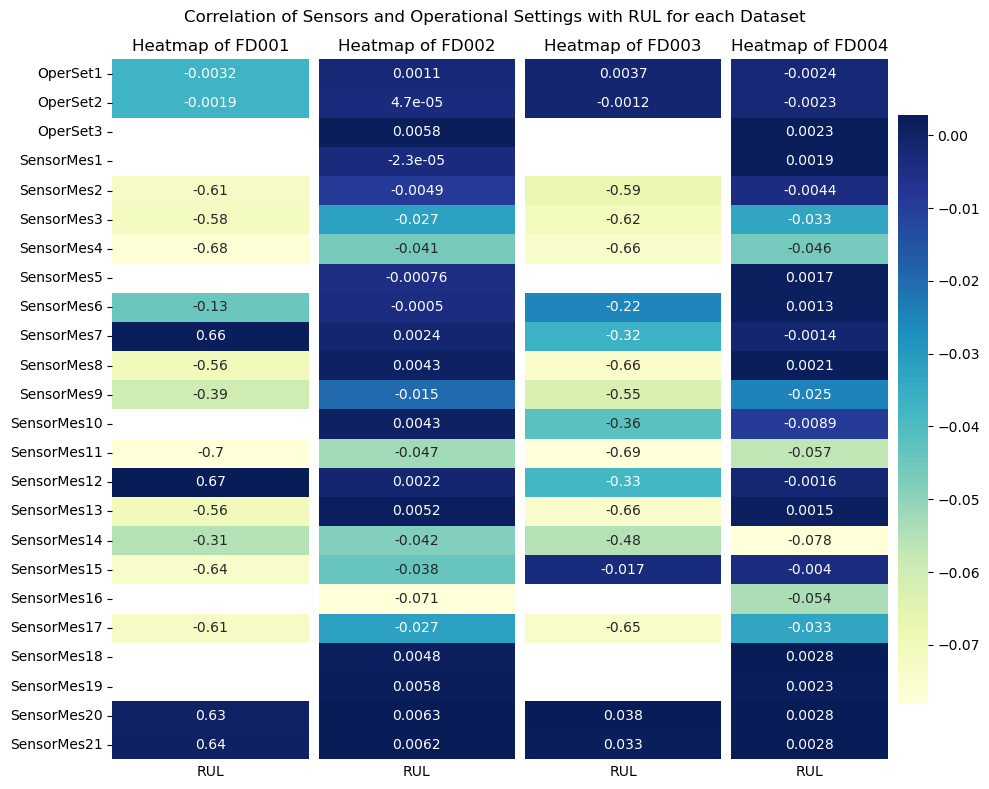

In [73]:
def correl_analysis(df1, df2, df3, df4, columns_of_interest):

    operSets = ["OperSet" + str(i) for i in range(1, 4)]  # 1, 2 et 3
    sensorMes = ["SensorMes" + str(j) for j in range(1, 22)]  # de 1 à 21
    columns_of_interest = operSets + sensorMes
    
    # Calculer la corrélation avec 'RUL' pour chaque dataset et exclure 'RUL' lui-même des résultats
    corr_matrix1 = df1[columns_of_interest + ['RUL']].corr()['RUL'].drop('RUL')
    corr_matrix2 = df2[columns_of_interest + ['RUL']].corr()['RUL'].drop('RUL')
    corr_matrix3 = df3[columns_of_interest + ['RUL']].corr()['RUL'].drop('RUL')
    corr_matrix4 = df4[columns_of_interest + ['RUL']].corr()['RUL'].drop('RUL')
    
    # Créer des sous-graphiques pour afficher les heatmaps côte à côte
    fig, axes = plt.subplots(1, 4, figsize=(10, 8))  # Ajustez la largeur ici à 16 pour 80% de 20
    
    # Heatmap pour FD001
    sns.heatmap(corr_matrix1.values.reshape(-1, 1), annot=True, cmap='YlGnBu', cbar=False, 
                ax=axes[0], yticklabels=columns_of_interest)
    axes[0].set_title('Heatmap of FD001')
    axes[0].set_xticks([])  # Enlever les ticks de l'axe x
    axes[0].set_xlabel('RUL')  # Ajouter "RUL" comme label de l'axe x
    
    # Heatmap pour FD002 (sans yticklabels)
    sns.heatmap(corr_matrix2.values.reshape(-1, 1), annot=True, cmap='YlGnBu', cbar=False, 
                ax=axes[1], yticklabels=False)
    axes[1].set_title('Heatmap of FD002')
    axes[1].set_xticks([])  # Enlever les ticks de l'axe x
    axes[1].set_xlabel('RUL')  # Ajouter "RUL" comme label de l'axe x
    
    # Heatmap pour FD003 (sans yticklabels)
    sns.heatmap(corr_matrix3.values.reshape(-1, 1), annot=True, cmap='YlGnBu', cbar=False, 
                ax=axes[2], yticklabels=False)
    axes[2].set_title('Heatmap of FD003')
    axes[2].set_xticks([])  # Enlever les ticks de l'axe x
    axes[2].set_xlabel('RUL')  # Ajouter "RUL" comme label de l'axe x
    
    # Heatmap pour FD004 (sans yticklabels)
    sns.heatmap(corr_matrix4.values.reshape(-1, 1), annot=True, cmap='YlGnBu', ax=axes[3], 
                yticklabels=False)
    axes[3].set_title('Heatmap of FD004')
    axes[3].set_xticks([])  # Enlever les ticks de l'axe x
    axes[3].set_xlabel('RUL')  # Ajouter "RUL" comme label de l'axe x
    
    # Ajouter un titre global
    fig.suptitle('Correlation of Sensors and Operational Settings with RUL for each Dataset')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Réduire l'espace entre les sous-graphiques à 0.1 ou moins si besoin
    plt.show()

# Appel de la fonction
correl_analysis(train_fd001, train_fd002, train_fd003, train_fd004, columnsNames)


In [23]:
'''def my_sns(df):
  sns.set()
  fig = plt.figure(figsize = [15,10])
  cols = df.columns
  cnt = 1
  for col in cols :
      plt.subplot(8,4,cnt)
      sns.histplot(df[col],color='blue')
      cnt+=1
  plt.tight_layout()
  plt.show()

#my_sns(train_fd001)
my_sns(train_fd002)
#my_sns(train_fd003)
#my_sns(train_fd004)'''

"def my_sns(df):\n  sns.set()\n  fig = plt.figure(figsize = [15,10])\n  cols = df.columns\n  cnt = 1\n  for col in cols :\n      plt.subplot(8,4,cnt)\n      sns.histplot(df[col],color='blue')\n      cnt+=1\n  plt.tight_layout()\n  plt.show()\n\n#my_sns(train_fd001)\nmy_sns(train_fd002)\n#my_sns(train_fd003)\n#my_sns(train_fd004)"

In [15]:
def correl(df):
    sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
    fig=plt.gcf()
    fig.set_size_inches(20,20)
    plt.show()

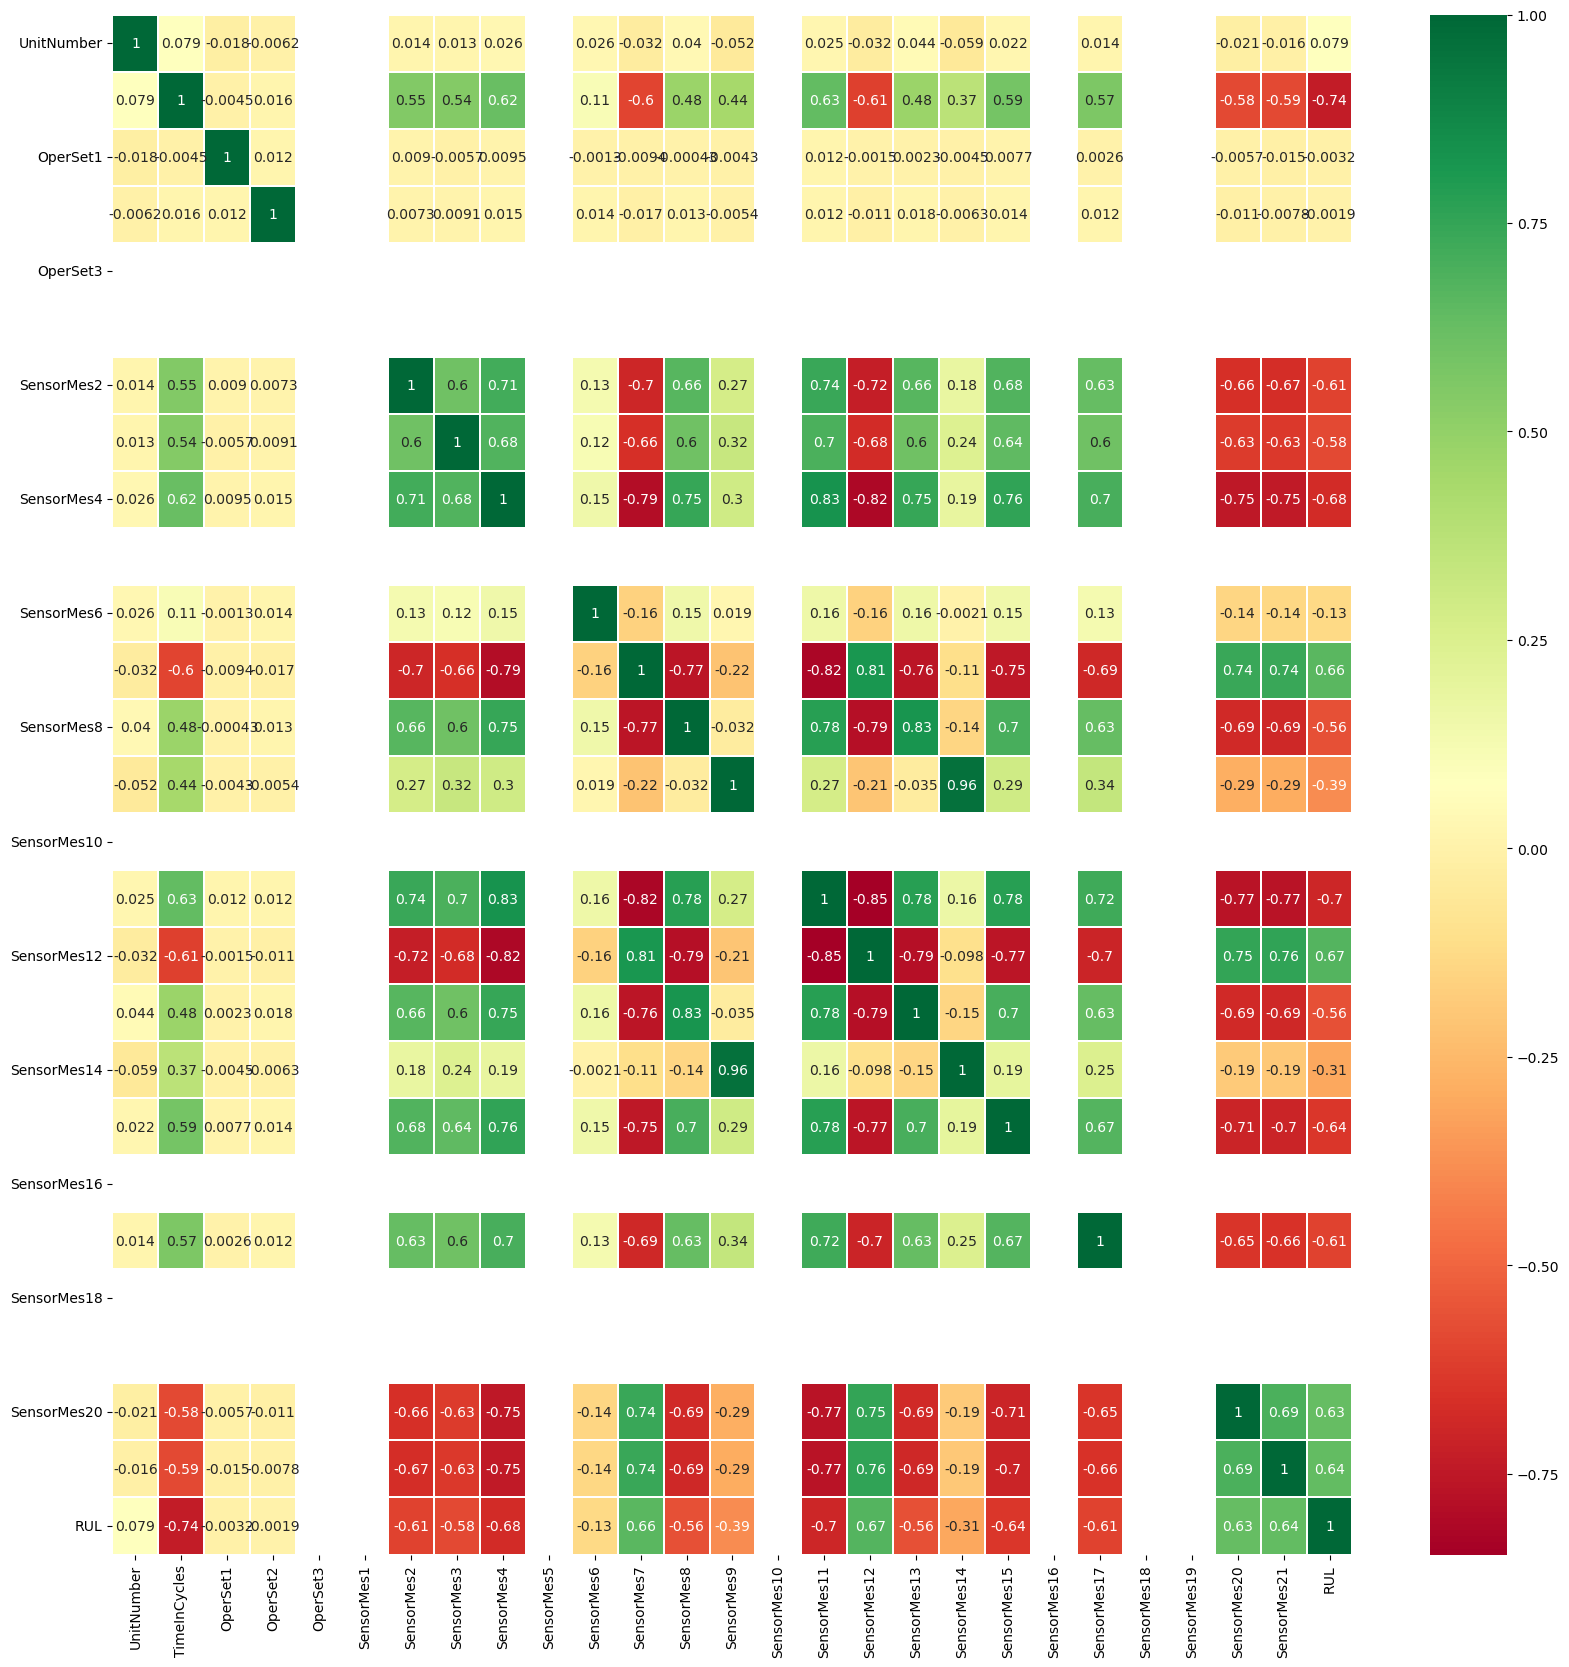

In [16]:
correl(train_fd001)

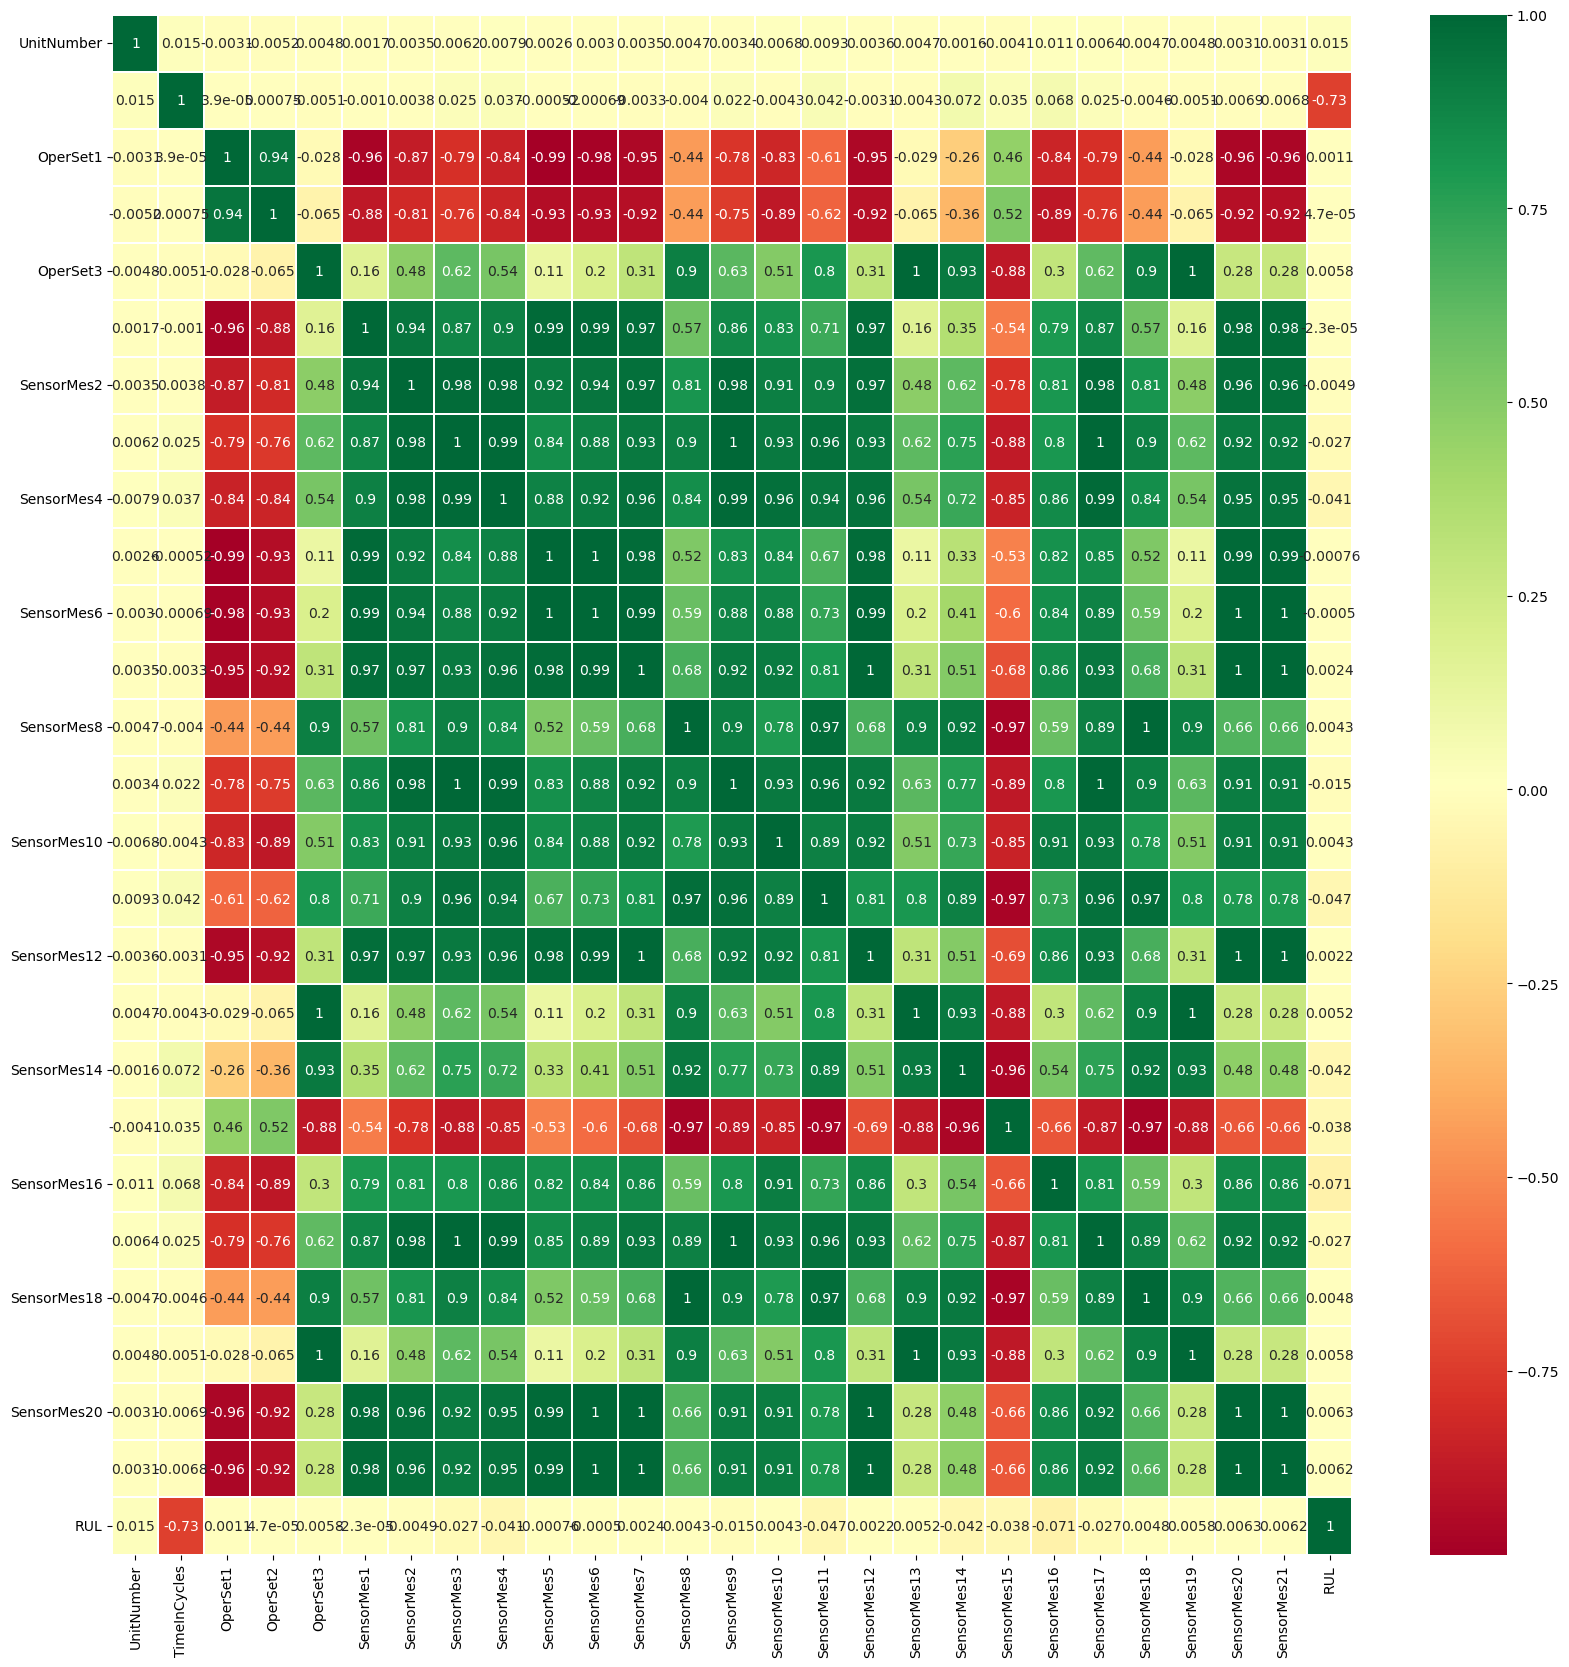

In [17]:
correl(train_fd002)

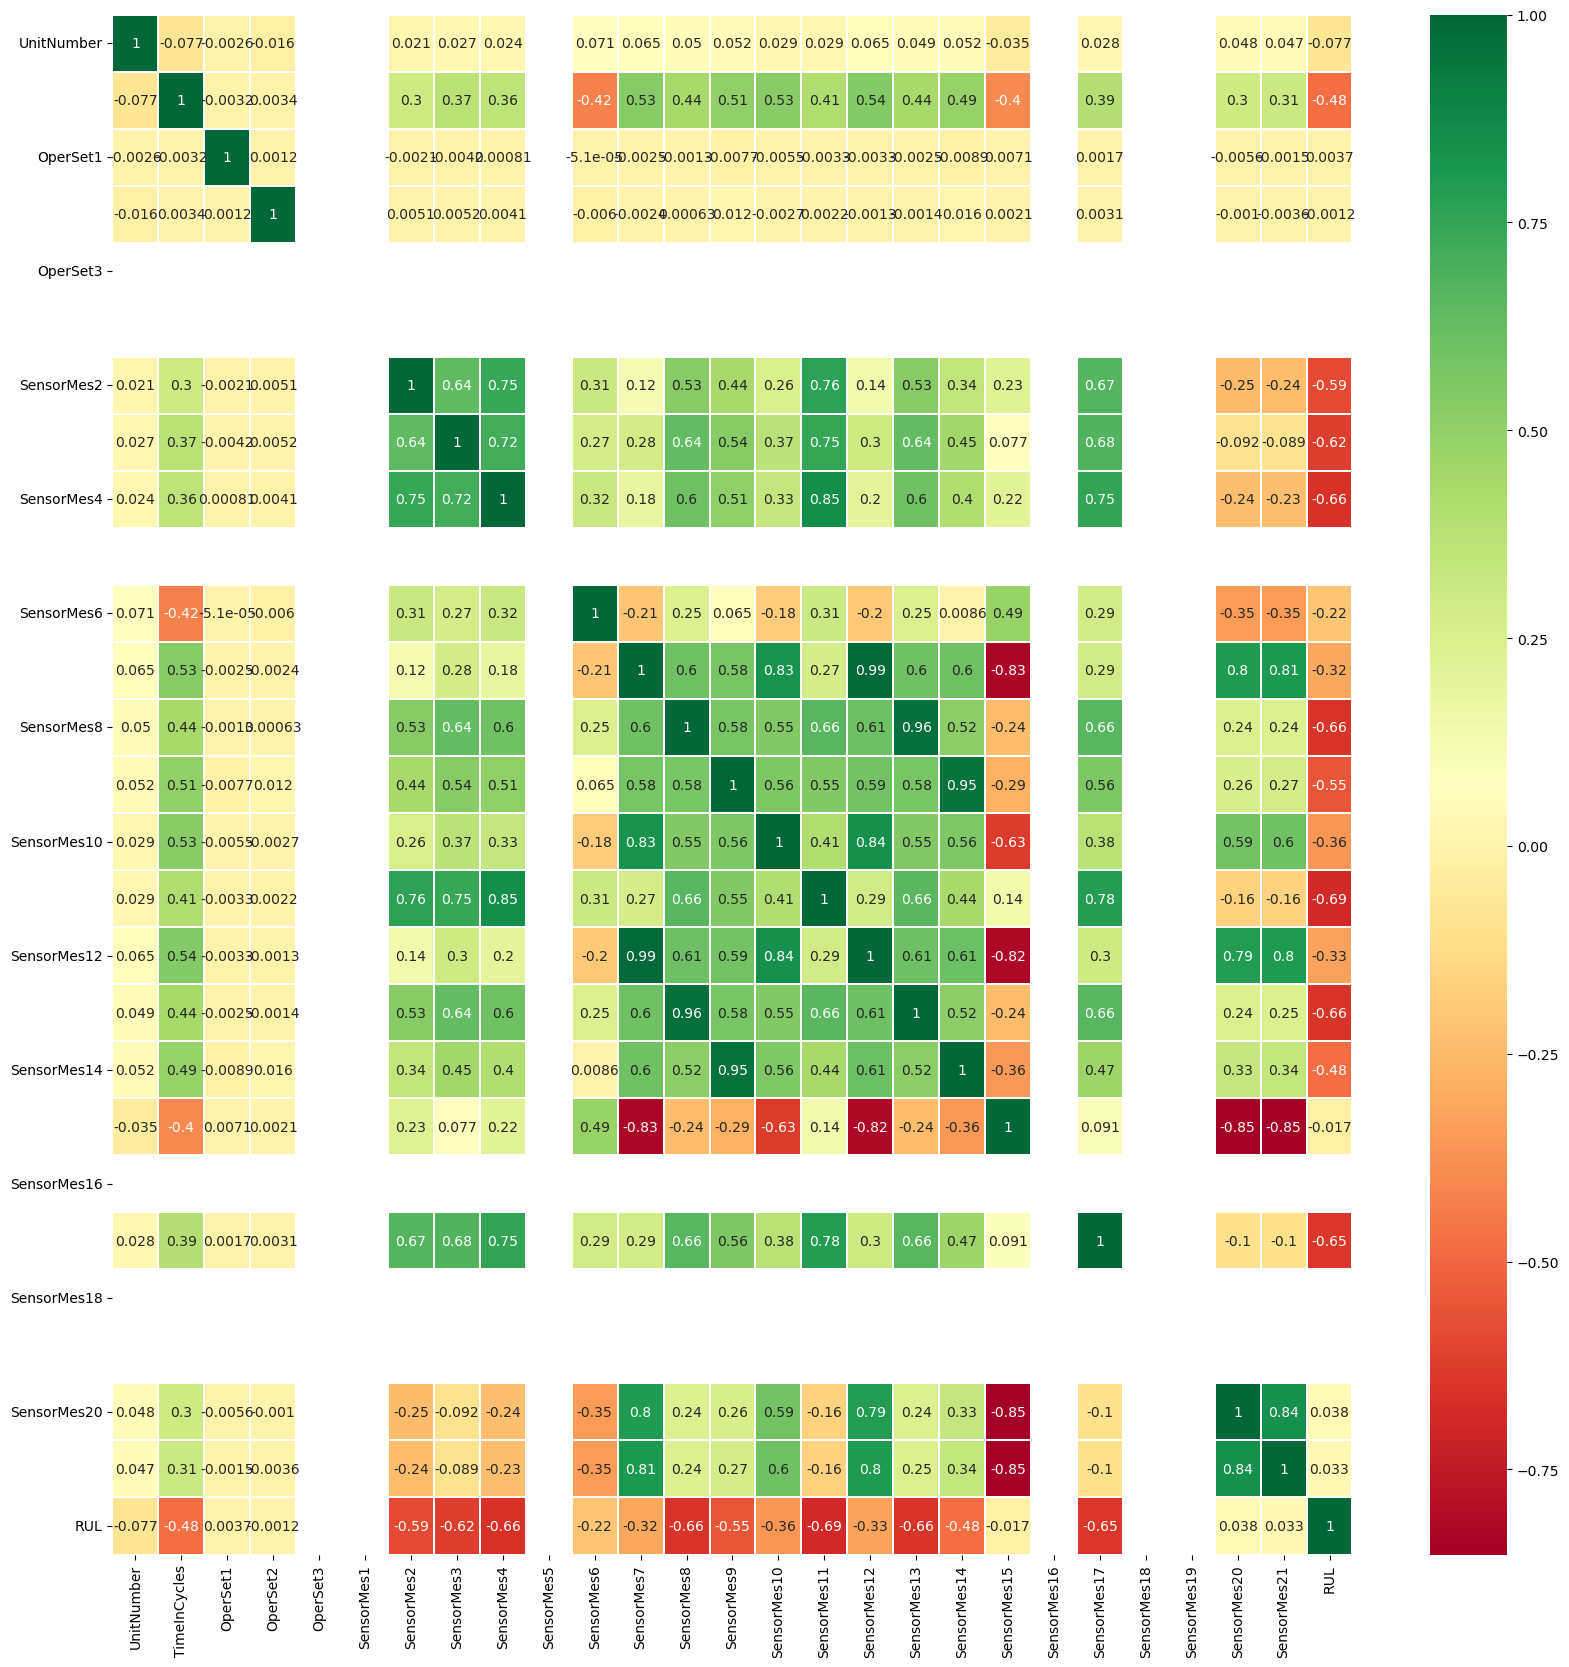

In [18]:
correl(train_fd003)

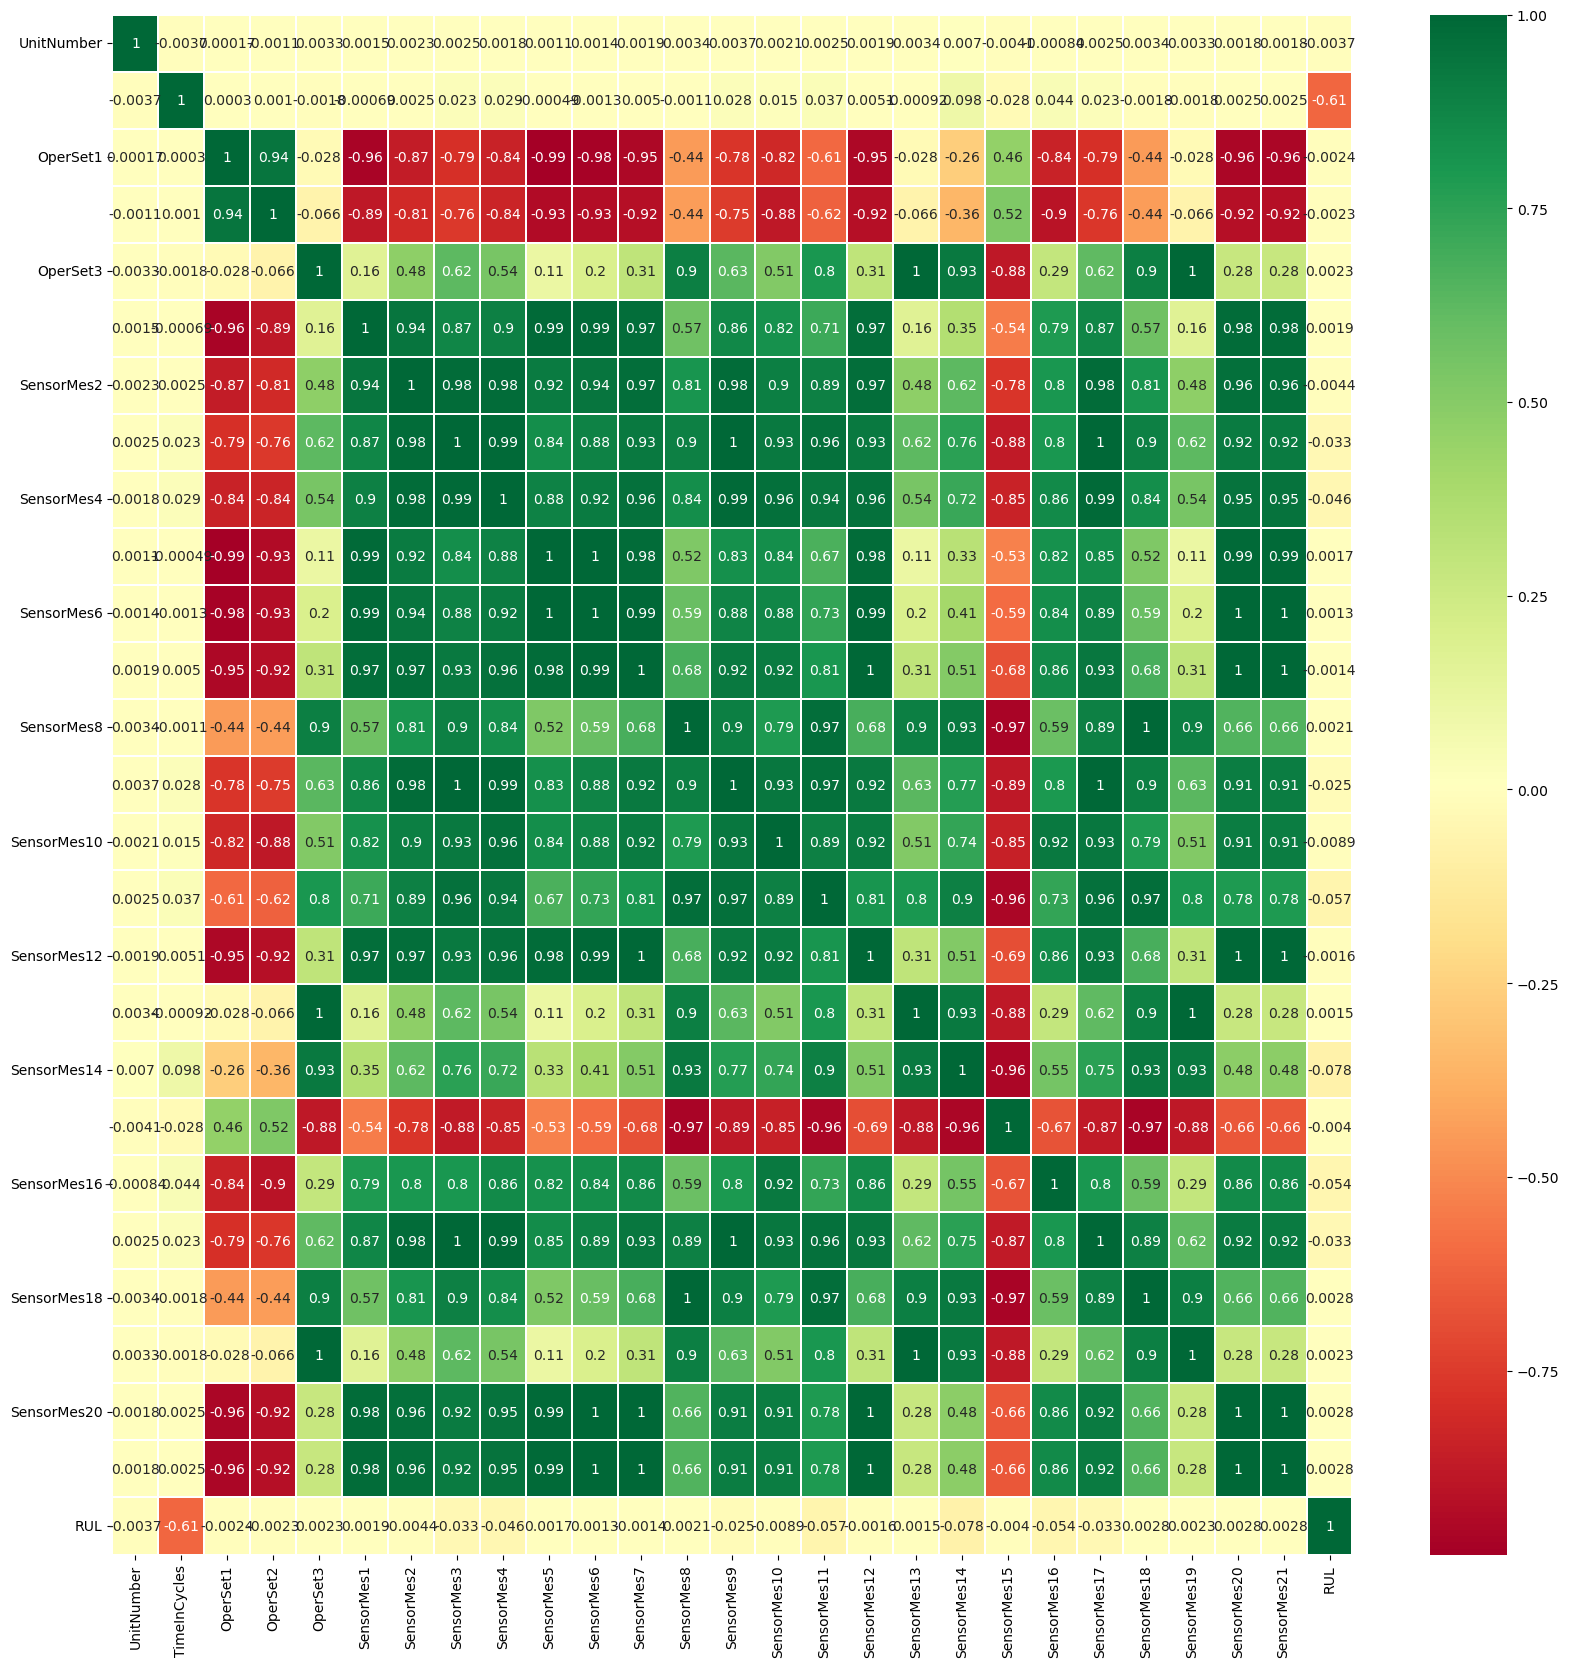

In [19]:
correl(train_fd004)

In [20]:
def correlation_analyz(df, seuil):
  # Calculer la corrélation entre les variables avec différentes méthodes
  corr_pearson = df.corr(method='pearson')
  corr_spearman = df.corr(method='spearman')
  corr_kendall = df.corr(method='kendall')

  # Colonnes avec corrélation plus faible que le seuil pour chaque méthode
  colonnes_faible_corr_pearson = corr_pearson.loc[corr_pearson['RUL'].abs() < seuil].index.tolist()
  colonnes_faible_corr_spearman = corr_spearman.loc[corr_spearman['RUL'].abs() < seuil].index.tolist()
  colonnes_faible_corr_kendall = corr_kendall.loc[corr_kendall['RUL'].abs() < seuil].index.tolist()

  # Afficher les colonnes avec corrélation plus faible que le seuil pour chaque méthode
  print("Colonnes avec corrélation plus faible que", seuil, "pour la corrélation de Pearson:")
  print(colonnes_faible_corr_pearson)
  print("\nColonnes avec corrélation plus faible que", seuil, "pour la corrélation de Spearman:")
  print(colonnes_faible_corr_spearman)
  print("\nColonnes avec corrélation plus faible que", seuil, "pour la corrélation de Kendall:")
  print(colonnes_faible_corr_kendall)

In [21]:
correlation_analyz(train_fd001, 0.4)

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes9', 'SensorMes14']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes9', 'SensorMes14']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes9', 'SensorMes14']


In [22]:
correlation_analyz(train_fd002, 0.05)

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes2', 'SensorMes3', 'SensorMes4', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes11', 'SensorMes12', 'SensorMes13', 'SensorMes14', 'SensorMes15', 'SensorMes17', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes6', 'SensorMes10', 'SensorMes18', 'SensorMes19']

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes6', 'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes18', 'SensorMes19']


In [23]:
correlation_analyz(train_fd003, 0.4)

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes10', 'SensorMes12', 'SensorMes15', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes12', 'SensorMes15', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.4 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'SensorMes6', 'SensorMes7', 'SensorMes10', 'SensorMes12', 'SensorMes14', 'SensorMes15', 'SensorMes20', 'SensorMes21']


In [24]:
correlation_analyz(train_fd004, 0.05)

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Pearson:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes2', 'SensorMes3', 'SensorMes4', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes8', 'SensorMes9', 'SensorMes10', 'SensorMes12', 'SensorMes13', 'SensorMes15', 'SensorMes17', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Spearman:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes12', 'SensorMes15', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']

Colonnes avec corrélation plus faible que 0.05 pour la corrélation de Kendall:
['UnitNumber', 'OperSet1', 'OperSet2', 'OperSet3', 'SensorMes1', 'SensorMes5', 'SensorMes6', 'SensorMes7', 'SensorMes10', 'SensorMes12', 'SensorMes15', 'SensorMes18', 'SensorMes19', 'SensorMes20', 'SensorMes21']


# **Columns to drop**

In [25]:
def drop_columns(train, test, wich):
    if wich == 1:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [3, 6, 8, 9, 13, 14]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 2:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 10, 18, 19]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 3:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [6, 7, 10, 12, 15, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 4:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 6, 7, 12, 15, 18, 19, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
        
    # drop columns 
    drop_cols=True
    if(drop_cols == True):
      train = train.drop(cols_to_drop, axis=1)
      test = test.drop(cols_to_drop, axis=1)
    return train, test

In [27]:
train1, test1 = drop_columns(train_fd001, test_fd001, 1)

In [28]:
train2, test2 = drop_columns(train_fd002, test_fd002, 2)

In [29]:
train3, test3 = drop_columns(train_fd003, test_fd003, 3)

In [30]:
train4, test4 = drop_columns(train_fd004, test_fd004, 4)

In [31]:
train1

,UnitNumber,TimeInCycles,OperSet3,SensorMes1,SensorMes2,SensorMes4,SensorMes5,SensorMes7,SensorMes10,SensorMes11,SensorMes12,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,100.0,518.67,641.82,1400.60,14.62,554.36,1.3,47.47,521.66,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,100.0,518.67,642.15,1403.14,14.62,553.75,1.3,47.49,522.28,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,100.0,518.67,642.35,1404.20,14.62,554.26,1.3,47.27,522.42,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,100.0,518.67,642.35,1401.87,14.62,554.45,1.3,47.13,522.86,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,100.0,518.67,642.37,1406.22,14.62,554.00,1.3,47.28,522.19,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,100.0,518.67,643.49,1428.63,14.62,551.43,1.3,48.07,519.49,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,100.0,518.67,643.54,1433.58,14.62,550.86,1.3,48.04,519.68,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,100.0,518.67,643.42,1428.18,14.62,550.94,1.3,48.09,520.01,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,100.0,518.67,643.23,1426.53,14.62,550.68,1.3,48.39,519.67,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
